# Model Selection and Feature Importance

In total, we've trained 12 'vanilla' models thus far combining an algorithm with a resampling (or class weight balancing) method. If we wanted to optimize recall, then the top two models would be XGBoost with random under sampling and XGBoost with random oversampling.  Unfortunately these two models have low precision values that are concerning to the potential business client.  In other words, while these models are able to capture a high percentage of the actual fraud cases, it also mislabels a significant number of valid transactions as fraudulent.

We are considering the situation where false negatives and false positives are equally costly to this particular credit card company.  As a result, our objective is to optimize the f1-score.

Taking a look at the f1-score, our top three models are:

<b>1. Random Forest with random over sampling </b>

<b>2. Random Forest with SMOTE</b>

<b>3. XGBoost with SMOTE</b>


## Plan:

- Apply hyperparameter tuning to these three models to see if we can see any make further improvements on f1-score and decide on our model from there. 
    - Compute precision, recall, f1, and support for both the train and test sets
    - Graph the ROC curve, the Precision-Recall curve, and calculate the area under both of those curves.
- After model selection, we will explore feature importance and feature impact.

## Imports

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
import xgboost as xgb

In [2]:
X_train = pd.read_csv('../raw_data/X_train_scaled.csv', index_col=0)
y_train = pd.read_csv('../raw_data/y_train.csv', index_col=0)
X_train_rus = pd.read_csv('../raw_data/X_train_rus.csv', index_col=0)
y_train_rus = pd.read_csv('../raw_data/y_train_rus.csv', index_col=0)
X_train_ros = pd.read_csv('../raw_data/X_train_ros.csv', index_col=0)
y_train_ros = pd.read_csv('../raw_data/y_train_ros.csv', index_col=0)
X_train_sm = pd.read_csv('../raw_data/X_train_sm.csv', index_col=0)
y_train_sm = pd.read_csv('../raw_data/y_train_sm.csv', index_col=0)

X_test = pd.read_csv('../raw_data/X_test_scaled.csv', index_col=0)
y_test = pd.read_csv('../raw_data/y_test.csv', index_col=0)

metrics = pd.read_csv('../raw_data/metrics.csv', index_col=0)

Convert to numpy.

In [15]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy().ravel()
X_train_rus_np = X_train_rus.to_numpy()
y_train_rus_np = y_train_rus.to_numpy().ravel()
X_train_ros_np = X_train_ros.to_numpy()
y_train_ros_np = y_train_ros.to_numpy().ravel()
X_train_sm_np = X_train_sm.to_numpy()
y_train_sm_np = y_train_sm.to_numpy().ravel()

X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy().ravel()

Create a function to add results to our metrics table:

In [58]:
def add_metrics(algorithm, class_balancing, train_report, test_report):
    new_row = {'Algorithm':algorithm,
              'Class Balancing':class_balancing,
              'Train Precision': train_report['fraud']['precision'],
              'Train Recall': train_report['fraud']['recall'],
              'Train f1': train_report['fraud']['f1-score'],
              'Train Support': train_report['fraud']['support'],
              'Test Precision': test_report['fraud']['precision'],
              'Test Recall': test_report['fraud']['recall'],
              'Test f1': test_report['fraud']['f1-score'],
              'Test Support': test_report['fraud']['support']}
    
    global metrics
    
    metrics = metrics.append(new_row, ignore_index = True)

## 1. Hyperparameter tuning Random Forest with Random Over Sampling

In [14]:
from pprint import pprint

# Number of trees in random forest
n_estimators = [200]

#criterion
criterion = ['gini', 'entropy']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 4)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion':criterion}

pprint(random_grid)

{'criterion': ['gini', 'entropy'],
 'max_depth': [10, 40, 70, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200]}


In [16]:
rf_ros = RandomForestClassifier()

rf_ros_cv = RandomizedSearchCV(estimator = rf_ros, 
                               param_distributions = random_grid, 
                               scoring = 'f1',
                               n_iter = 20, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = 4)

rf_ros_cv.fit(X_train_ros_np, y_train_ros_np)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 102.6min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 179.7min finished


[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=40, criterion=gini 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=40, criterion=gini, total=12.2min
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=70, criterion=gini 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=70, criterion=gini, total=12.3min
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, criterion=gini 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, criterion=gini, total=12.4min
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=100, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=100, criterion=entropy, total=12.5min
[CV] n_estimators=200, m

[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=70, criterion=gini 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=70, criterion=gini, total=11.9min
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=70, criterion=gini 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=70, criterion=gini, total=12.3min
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100, criterion=entropy, total=12.6min
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=100, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=100, criterion=entropy, total=12.4min
[CV] n_estimators=20

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 40, 70, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200]},
                   random_state=42, scoring='f1', verbose=2)

In [17]:
pd.DataFrame(rf_ros_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,708.321501,3.573280,29.744012,0.217035,200,5,1,auto,40,gini,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.999763,0.999785,0.999766,0.999771,0.000010,1
1,698.991722,11.283613,29.610636,0.439115,200,2,4,auto,70,gini,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.999338,0.999355,0.999338,0.999344,0.000008,16
2,721.003489,3.445269,29.603775,0.817229,200,2,1,sqrt,100,entropy,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.999760,0.999770,0.999765,0.999765,0.000004,4
3,718.541384,3.575780,29.643266,0.180873,200,2,4,auto,None,gini,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.999352,0.999375,0.999341,0.999356,0.000014,13
4,723.172807,7.277792,30.611947,0.407359,200,5,1,auto,100,entropy,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.999747,0.999763,0.999766,0.999759,0.000008,6
5,522.219221,3.555487,17.288617,0.427325,200,2,4,sqrt,10,gini,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.952305,0.953566,0.951936,0.952603,0.000698,19
6,731.786970,4.146571,30.847317,0.333755,200,2,4,auto,40,gini,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.999351,0.999362,0.999354,0.999356,0.000005,14
7,729.427272,1.723130,31.858890,0.264374,200,10,2,sqrt,100,gini,"{'n_estimators': 200, 'min_samples_split': 10,...",0.999610,0.999623,0.999600,0.999611,0.000009,8
8,720.024050,1.191622,30.642797,0.229894,200,10,2,auto,40,entropy,"{'n_estimators': 200, 'min_samples_split': 10,...",0.999608,0.999631,0.999617,0.999619,0.000009,7
9,725.623790,3.002614,30.953490,0.391841,200,5,1,sqrt,40,entropy,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.999753,0.999764,0.999765,0.999761,0.000006,5


In [19]:
rf_ros_cv.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'criterion': 'gini'}

Having run RandomizedSearchCV, we will now fit the model with best parameters onto the entire training dataset.

In [22]:
rf_ros_best = RandomForestClassifier(**rf_ros_cv.best_params_, random_state = 42)

rf_ros_best.fit(X_train_ros_np, y_train_ros_np)

y_pred_train_1 = rf_ros_best.predict(X_train_ros_np)
y_pred_test_1 = rf_ros_best.predict(X_test_np)

### 1a. Confusion matrix

In [23]:
cm_train_1 = confusion_matrix(y_train_ros_np,y_pred_train_1)
cm_test_1 = confusion_matrix(y_test_np,y_pred_test_1)

Text(0.5, 1.0, 'Random Forest ROS - Testing confusion matrix')

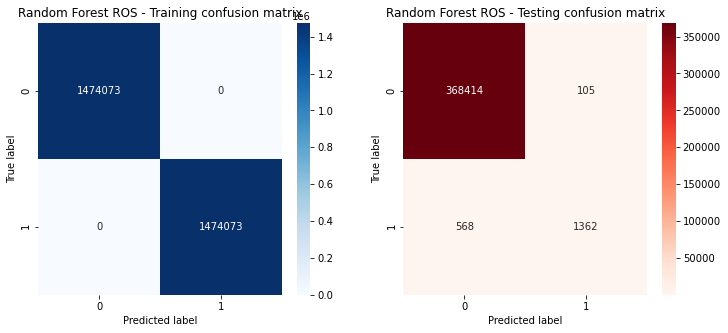

In [26]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_train_1, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('Random Forest ROS - Training confusion matrix')

sns.heatmap(cm_test_1, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('Random Forest ROS - Testing confusion matrix')

### 1b. Classification Report

In [25]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_ros_np, y_pred_train_1, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_1, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00   1474073
       fraud       1.00      1.00      1.00   1474073

    accuracy                           1.00   2948146
   macro avg       1.00      1.00      1.00   2948146
weighted avg       1.00      1.00      1.00   2948146

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00    368519
       fraud       0.93      0.71      0.80      1930

    accuracy                           1.00    370449
   macro avg       0.96      0.85      0.90    370449
weighted avg       1.00      1.00      1.00    370449



Add these results to our metrics dataframe

In [59]:
train_report_1 = classification_report(y_train_ros_np, y_pred_train_1, target_names=target_names, output_dict = True)
test_report_1 = classification_report(y_test_np, y_pred_test_1, target_names=target_names, output_dict = True)

add_metrics('Random Forest (RandomSearch)', 'Random Over Sampling', train_report_1, test_report_1)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930
1,Logistic Regression,Random Over Sampling,0.897946,0.858799,0.877937,1474073,0.043753,0.854404,0.083243,1930
2,Logistic Regression,SMOTE,0.900986,0.863715,0.881957,1474073,0.045073,0.854922,0.085632,1930
3,Logistic Regression,Balanced weight,0.044084,0.858568,0.083862,7721,0.043811,0.854404,0.083348,1930
4,Random Forest,Random Under Sampling,1.000000,1.000000,1.000000,7721,0.199521,0.949223,0.329734,1930
5,Random Forest,Random Over Sampling,1.000000,1.000000,1.000000,1474073,0.931694,0.706736,0.803771,1930
6,Random Forest,SMOTE,1.000000,1.000000,1.000000,1474073,0.775593,0.796891,0.786098,1930
7,Random Forest,Balanced weight,1.000000,0.999352,0.999676,7721,0.961029,0.638860,0.767507,1930
8,XGBoost,Random Under Sampling,0.999870,0.999741,0.999806,7721,0.192803,0.977202,0.322063,1930
9,XGBoost,Random Over Sampling,0.993546,1.000000,0.996763,1474073,0.418360,0.949223,0.580758,1930


### 1c. ROC Curve

In [120]:
# get predicted probabilities
y_scores_1 = rf_ros_best.predict_proba(X_test_np)[:,1]

In [121]:
y_scores_1.shape

(370449,)

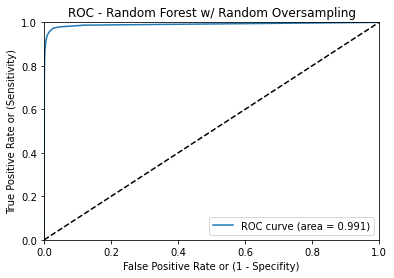

In [122]:
# Compute fpr, tpr, thresholds and roc auc
fpr1, tpr1, thresholds1 = roc_curve(y_test_np, y_scores_1)
roc_auc1 = auc(fpr1, tpr1)

# Plot ROC curve
plt.plot(fpr1, tpr1, label='ROC curve (area = %0.3f)' % roc_auc1)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('ROC - Random Forest w/ Random Oversampling')
plt.legend(loc="lower right")

### 1d. Precision-Recall Curve and AUPRC

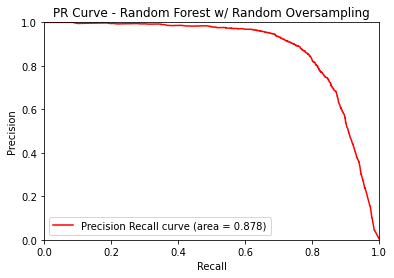

In [129]:
precision1, recall1, threshold1 = precision_recall_curve(y_test_np, y_scores_1)
# Use AUC function to calculate the area under the curve of precision recall curve
pr_auc1 = auc(recall1, precision1)

plt.plot(recall1, precision1, label='Precision Recall curve (area = %0.3f)' % pr_auc1, color = 'red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve - Random Forest w/ Random Oversampling')
plt.legend(loc="lower left")

## 2. Hyperparameter tuning Random Forest with SMOTE

In [29]:
rf_sm = RandomForestClassifier()

rf_sm_cv = RandomizedSearchCV(estimator = rf_sm, 
                               param_distributions = random_grid, 
                               scoring = 'f1',
                               n_iter = 20, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = 4)

rf_sm_cv.fit(X_train_sm_np, y_train_sm_np)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 166.7min


[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=70, criterion=gini 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=70, criterion=gini, total=19.3min
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=70, criterion=gini 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=70, criterion=gini, total=19.6min
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100, criterion=entropy, total=21.5min
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=100, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=100, criterion=entropy, total=21.4min
[CV] n_estimators=20

[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 296.7min finished


[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=40, criterion=gini 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=40, criterion=gini, total=19.7min
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=100, criterion=entropy, total=22.0min
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, criterion=gini 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, criterion=gini, total=20.1min
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=gini 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=gini, total=12.2min
[CV] n_estimators=200, m

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 40, 70, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200]},
                   random_state=42, scoring='f1', verbose=2)

In [30]:
rf_sm_cv.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'criterion': 'gini'}

Having run RandomizedSearchCV, we will now fit the model with best parameters onto the entire training dataset.

In [130]:
rf_sm_best = RandomForestClassifier(**rf_sm_cv.best_params_, random_state = 42)

rf_sm_best.fit(X_train_sm_np, y_train_sm_np)

y_pred_train_2 = rf_sm_best.predict(X_train_sm_np)
y_pred_test_2 = rf_sm_best.predict(X_test_np)

### 2a. Confusion Matrix

In [32]:
cm_train_2 = confusion_matrix(y_train_sm_np,y_pred_train_2)
cm_test_2 = confusion_matrix(y_test_np,y_pred_test_2)

Text(0.5, 1.0, 'Random Forest SMOTE - Testing confusion matrix')

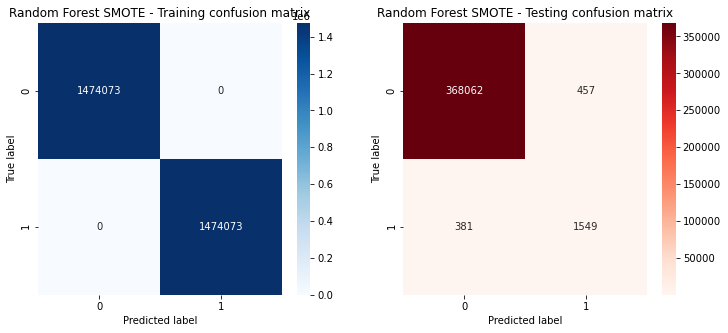

In [33]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_train_2, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('Random Forest SMOTE - Training confusion matrix')

sns.heatmap(cm_test_2, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('Random Forest SMOTE - Testing confusion matrix')

### 2b. Classification Report

In [35]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_sm_np, y_pred_train_2, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_2, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00   1474073
       fraud       1.00      1.00      1.00   1474073

    accuracy                           1.00   2948146
   macro avg       1.00      1.00      1.00   2948146
weighted avg       1.00      1.00      1.00   2948146

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00    368519
       fraud       0.77      0.80      0.79      1930

    accuracy                           1.00    370449
   macro avg       0.89      0.90      0.89    370449
weighted avg       1.00      1.00      1.00    370449



Add these results to our metrics dataframe

In [60]:
train_report_2 = classification_report(y_train_sm_np, y_pred_train_2, target_names=target_names, output_dict = True)
test_report_2 = classification_report(y_test_np, y_pred_test_2, target_names=target_names, output_dict = True)

add_metrics('Random Forest (RandomSearch)', 'SMOTE', train_report_2, test_report_2)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930
1,Logistic Regression,Random Over Sampling,0.897946,0.858799,0.877937,1474073,0.043753,0.854404,0.083243,1930
2,Logistic Regression,SMOTE,0.900986,0.863715,0.881957,1474073,0.045073,0.854922,0.085632,1930
3,Logistic Regression,Balanced weight,0.044084,0.858568,0.083862,7721,0.043811,0.854404,0.083348,1930
4,Random Forest,Random Under Sampling,1.000000,1.000000,1.000000,7721,0.199521,0.949223,0.329734,1930
5,Random Forest,Random Over Sampling,1.000000,1.000000,1.000000,1474073,0.931694,0.706736,0.803771,1930
6,Random Forest,SMOTE,1.000000,1.000000,1.000000,1474073,0.775593,0.796891,0.786098,1930
7,Random Forest,Balanced weight,1.000000,0.999352,0.999676,7721,0.961029,0.638860,0.767507,1930
8,XGBoost,Random Under Sampling,0.999870,0.999741,0.999806,7721,0.192803,0.977202,0.322063,1930
9,XGBoost,Random Over Sampling,0.993546,1.000000,0.996763,1474073,0.418360,0.949223,0.580758,1930


### 2c. ROC Curve

In [131]:
# get predicted probabilities
y_scores_2 = rf_sm_best.predict_proba(X_test_np)[:,1]

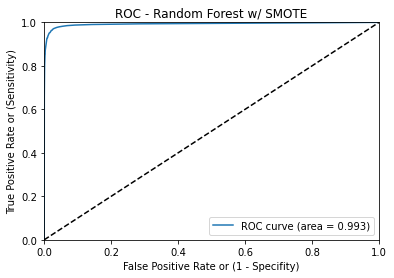

In [132]:
# Compute fpr, tpr, thresholds and roc auc
fpr2, tpr2, thresholds2 = roc_curve(y_test_np, y_scores_2)
roc_auc2 = auc(fpr2, tpr2)

# Plot ROC curve
plt.plot(fpr2, tpr2, label='ROC curve (area = %0.3f)' % roc_auc2)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('ROC - Random Forest w/ SMOTE')
plt.legend(loc="lower right")

### 2d. Precision-Recall Curve and AUPRC

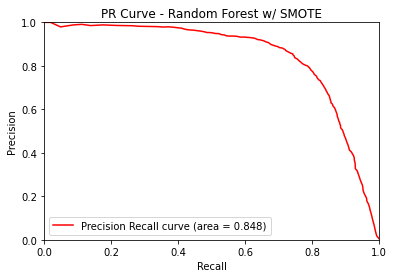

In [133]:
precision2, recall2, threshold2 = precision_recall_curve(y_test_np, y_scores_2)
# Use AUC function to calculate the area under the curve of precision recall curve
pr_auc2 = auc(recall2, precision2)

plt.plot(recall2, precision2, label='Precision Recall curve (area = %0.3f)' % pr_auc2, color = 'red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve - Random Forest w/ SMOTE')
plt.legend(loc="lower left")

## 3. Hyperparameter tuning XGBoost with SMOTE

In [41]:
params = { 'max_depth': [3, 5, 6, 10, 15],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

In [45]:
xg_sm = xgb.XGBClassifier(use_label_encoder=False)
xg_sm_cv = RandomizedSearchCV(xg_sm, 
                         param_distributions = params,
                         cv = 3,  
                         n_iter = 20,  
                         scoring = 'f1', 
                         verbose = 2, 
                         n_jobs = 4)

xg_sm_cv.fit(X_train_sm_np, y_train_sm_np)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 253.0min


[CV] subsample=0.7999999999999999, n_estimators=100, max_depth=3, learning_rate=0.01, colsample_bytree=0.5, colsample_bylevel=0.7999999999999999 
[15:54:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=0.7999999999999999, n_estimators=100, max_depth=3, learning_rate=0.01, colsample_bytree=0.5, colsample_bylevel=0.7999999999999999, total= 3.4min
[CV] subsample=0.6, n_estimators=100, max_depth=5, learning_rate=0.1, colsample_bytree=0.8999999999999999, colsample_bylevel=0.7999999999999999 
[15:58:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error

[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 437.7min finished


[23:12:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           use_label_encoder=False,
                                           validate_parameters=None,
                                           v

[CV] subsample=0.6, n_estimators=100, max_depth=5, learning_rate=0.1, colsample_bytree=0.8999999999999999, colsample_bylevel=0.7999999999999999 
[15:55:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=0.6, n_estimators=100, max_depth=5, learning_rate=0.1, colsample_bytree=0.8999999999999999, colsample_bylevel=0.7999999999999999, total= 5.9min
[CV] subsample=0.7999999999999999, n_estimators=1000, max_depth=6, learning_rate=0.3, colsample_bytree=0.6, colsample_bylevel=0.7 
[16:00:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. 

[CV] subsample=0.7999999999999999, n_estimators=100, max_depth=3, learning_rate=0.01, colsample_bytree=0.5, colsample_bylevel=0.7999999999999999 
[15:55:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=0.7999999999999999, n_estimators=100, max_depth=3, learning_rate=0.01, colsample_bytree=0.5, colsample_bylevel=0.7999999999999999, total= 3.4min
[CV] subsample=0.6, n_estimators=100, max_depth=5, learning_rate=0.1, colsample_bytree=0.8999999999999999, colsample_bylevel=0.7999999999999999 
[15:58:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error

In [46]:
pd.DataFrame(xg_sm_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_depth,param_learning_rate,param_colsample_bytree,param_colsample_bylevel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,200.709726,0.826715,1.077722,0.178279,0.8,100,3,0.01,0.5,0.8,"{'subsample': 0.7999999999999999, 'n_estimator...",0.924121,0.926830,0.926376,0.925776,0.001185,20
1,347.824841,3.765076,1.374929,0.103710,0.6,100,5,0.1,0.9,0.8,"{'subsample': 0.6, 'n_estimators': 100, 'max_d...",0.991177,0.991768,0.991142,0.991363,0.000287,16
2,3367.407471,63.160867,11.662892,0.335735,0.8,1000,6,0.3,0.6,0.7,"{'subsample': 0.7999999999999999, 'n_estimator...",0.996787,0.999670,0.999695,0.998717,0.001365,10
3,1947.766706,90.682203,4.520832,0.174891,0.8,1000,3,0.1,0.6,0.9,"{'subsample': 0.7999999999999999, 'n_estimator...",0.997322,0.998701,0.998829,0.998284,0.000682,11
4,1822.976337,30.894622,4.623957,0.135372,0.6,1000,3,0.2,0.5,0.6,"{'subsample': 0.6, 'n_estimators': 1000, 'max_...",0.997518,0.999356,0.999446,0.998773,0.000888,6
5,1733.119945,17.011212,5.886597,0.174441,0.7,500,6,0.01,0.6,0.8,"{'subsample': 0.7, 'n_estimators': 500, 'max_d...",0.987498,0.987740,0.988043,0.987760,0.000223,17
6,351.591053,3.765999,3.302631,0.173117,0.7,100,10,0.1,0.5,0.4,"{'subsample': 0.7, 'n_estimators': 100, 'max_d...",0.995981,0.996368,0.996726,0.996358,0.000305,15
7,3306.533613,315.872588,27.996933,2.601809,0.5,1000,15,0.3,0.4,0.6,"{'subsample': 0.5, 'n_estimators': 1000, 'max_...",0.997814,0.999655,0.999689,0.999053,0.000876,2
8,3170.084446,103.896302,12.037178,1.263514,0.9,1000,6,0.2,0.7,0.5,"{'subsample': 0.8999999999999999, 'n_estimator...",0.997086,0.999681,0.999708,0.998825,0.001230,5
9,192.275421,4.975593,1.158359,0.075261,0.7,100,3,0.1,0.7,0.7,"{'subsample': 0.7, 'n_estimators': 100, 'max_d...",0.972155,0.971710,0.971452,0.971773,0.000290,19


In [47]:
xg_sm_cv.best_params_

{'subsample': 0.5,
 'n_estimators': 100,
 'max_depth': 10,
 'learning_rate': 0.3,
 'colsample_bytree': 0.8999999999999999,
 'colsample_bylevel': 0.7999999999999999}

In [48]:
xg_sm_cv.best_score_

0.999111433558229

Having run RandomizedSearchCV, we will now fit the model with best parameters onto the entire training dataset.

In [49]:
xg_sm_final = xgb.XGBClassifier(**xg_sm_cv.best_params_, random_state = 42, use_label_encoder=False)

xg_sm_final.fit(X_train_sm_np, y_train_sm_np)

[08:20:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.7999999999999999, colsample_bynode=1,
              colsample_bytree=0.8999999999999999, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [61]:
y_pred_train_3 = xg_sm_final.predict(X_train_sm_np)
y_pred_test_3 = xg_sm_final.predict(X_test_np)

### 3a. Confusion Matrix

In [63]:
cm_train_3 = confusion_matrix(y_train_sm_np, y_pred_train_3)
cm_test_3 = confusion_matrix(y_test_np, y_pred_test_3)

Text(0.5, 1.0, 'XGBoost SMOTE final - Testing confusion matrix')

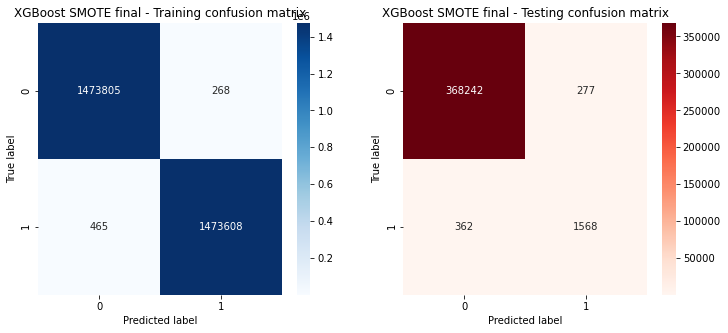

In [64]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_train_3, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('XGBoost SMOTE final - Training confusion matrix')

sns.heatmap(cm_test_3, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('XGBoost SMOTE final - Testing confusion matrix')

### 3b. Classification Report

In [65]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_sm_np, y_pred_train_3, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_3, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00   1474073
       fraud       1.00      1.00      1.00   1474073

    accuracy                           1.00   2948146
   macro avg       1.00      1.00      1.00   2948146
weighted avg       1.00      1.00      1.00   2948146

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00    368519
       fraud       0.85      0.81      0.83      1930

    accuracy                           1.00    370449
   macro avg       0.92      0.91      0.91    370449
weighted avg       1.00      1.00      1.00    370449



Add these results to our metrics table:

In [66]:
train_report_3 = classification_report(y_train_sm, y_pred_train_3, target_names=target_names, output_dict = True)
test_report_3 = classification_report(y_test, y_pred_test_3, target_names=target_names, output_dict = True)

add_metrics('XGBoost(post randomsearch)', 'SMOTE', train_report_3, test_report_3)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930
1,Logistic Regression,Random Over Sampling,0.897946,0.858799,0.877937,1474073,0.043753,0.854404,0.083243,1930
2,Logistic Regression,SMOTE,0.900986,0.863715,0.881957,1474073,0.045073,0.854922,0.085632,1930
3,Logistic Regression,Balanced weight,0.044084,0.858568,0.083862,7721,0.043811,0.854404,0.083348,1930
4,Random Forest,Random Under Sampling,1.000000,1.000000,1.000000,7721,0.199521,0.949223,0.329734,1930
5,Random Forest,Random Over Sampling,1.000000,1.000000,1.000000,1474073,0.931694,0.706736,0.803771,1930
6,Random Forest,SMOTE,1.000000,1.000000,1.000000,1474073,0.775593,0.796891,0.786098,1930
7,Random Forest,Balanced weight,1.000000,0.999352,0.999676,7721,0.961029,0.638860,0.767507,1930
8,XGBoost,Random Under Sampling,0.999870,0.999741,0.999806,7721,0.192803,0.977202,0.322063,1930
9,XGBoost,Random Over Sampling,0.993546,1.000000,0.996763,1474073,0.418360,0.949223,0.580758,1930


### 3c. ROC Curve

In [134]:
# get predicted probabilities
y_scores_3 = xg_sm_final.predict_proba(X_test_np)[:,1]

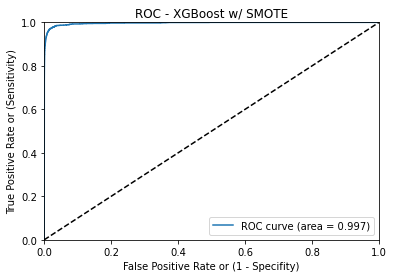

In [135]:
# Compute fpr, tpr, thresholds and roc auc
fpr3, tpr3, thresholds3 = roc_curve(y_test_np, y_scores_3)
roc_auc3 = auc(fpr3, tpr3)

# Plot ROC curve
plt.plot(fpr3, tpr3, label='ROC curve (area = %0.3f)' % roc_auc3)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('ROC - XGBoost w/ SMOTE')
plt.legend(loc="lower right")

### 3d. Precision-Recall Curve

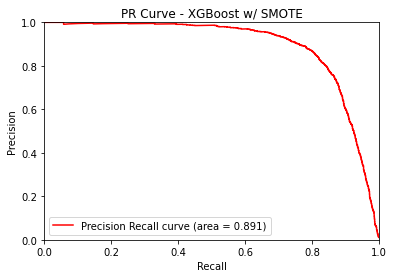

In [136]:
precision3, recall3, threshold3 = precision_recall_curve(y_test_np, y_scores_3)
# Use AUC function to calculate the area under the curve of precision recall curve
pr_auc3 = auc(recall3, precision3)

plt.plot(recall3, precision3, label='Precision Recall curve (area = %0.3f)' % pr_auc3, color = 'red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve - XGBoost w/ SMOTE')
plt.legend(loc="lower left")

## 4. Finetuning Hyperparameters of XGBoost with SMOTE

Based on our results from hyperparameter tuning three models, our best model so far is using the XGBoost algorithm combined with the SMOTE resampling method.

We will run one more round of RandomizedSearchCV to see if we can fine tune the best parameters from the previous round and improve performance any further.

In [70]:
xg_sm_cv.best_params_

{'subsample': 0.5,
 'n_estimators': 100,
 'max_depth': 10,
 'learning_rate': 0.3,
 'colsample_bytree': 0.8999999999999999,
 'colsample_bylevel': 0.7999999999999999}

In [72]:
params_2 = { 'max_depth': [9, 10, 11],
           'learning_rate': [0.25, 0.3, 0.35],
           'subsample': [0.45, 0.5, 0.55],
           'colsample_bytree': [0.85, 0.9, 0.95],
           'colsample_bylevel': [0.75, 0.8, 0.85],
           'n_estimators': [80, 100, 120]}

In [73]:
xg_sm2 = xgb.XGBClassifier(use_label_encoder=False)
xg_sm_cv2 = RandomizedSearchCV(xg_sm2, 
                         param_distributions = params_2,
                         cv = 3,  
                         n_iter = 20,  
                         scoring = 'f1', 
                         verbose = 2, 
                         n_jobs = 4)

xg_sm_cv2.fit(X_train_sm_np, y_train_sm_np)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 100.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 178.1min finished


[14:28:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] subsample=0.55, n_estimators=80, max_depth=11, learning_rate=0.3, colsample_bytree=0.85, colsample_bylevel=0.75 
[11:30:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=0.55, n_estimators=80, max_depth=11, learning_rate=0.3, colsample_bytree=0.85, colsample_bylevel=0.75, total= 9.6min
[CV] subsample=0.45, n_estimators=80, max_depth=11, learning_rate=0.3, colsample_bytree=0.9, colsample_bylevel=0.85

[CV] subsample=0.55, n_estimators=80, max_depth=11, learning_rate=0.3, colsample_bytree=0.85, colsample_bylevel=0.75 
[11:30:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=0.55, n_estimators=80, max_depth=11, learning_rate=0.3, colsample_bytree=0.85, colsample_bylevel=0.75, total= 9.9min
[CV] subsample=0.5, n_estimators=120, max_depth=9, learning_rate=0.25, colsample_bytree=0.9, colsample_bylevel=0.8 
[11:40:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                      

[CV] subsample=0.45, n_estimators=80, max_depth=11, learning_rate=0.3, colsample_bytree=0.9, colsample_bylevel=0.85 
[11:30:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=0.45, n_estimators=80, max_depth=11, learning_rate=0.3, colsample_bytree=0.9, colsample_bylevel=0.85, total= 9.5min
[CV] subsample=0.45, n_estimators=80, max_depth=11, learning_rate=0.3, colsample_bytree=0.9, colsample_bylevel=0.85 
[11:40:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[CV] subsample=0.55, n_estimators=80, max_depth=11, learning_rate=0.3, colsample_bytree=0.85, colsample_bylevel=0.75 
[11:30:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=0.55, n_estimators=80, max_depth=11, learning_rate=0.3, colsample_bytree=0.85, colsample_bylevel=0.75, total= 9.7min
[CV] subsample=0.5, n_estimators=120, max_depth=9, learning_rate=0.25, colsample_bytree=0.9, colsample_bylevel=0.8 
[11:40:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

In [74]:
xg_sm_cv2.best_params_

{'subsample': 0.45,
 'n_estimators': 80,
 'max_depth': 11,
 'learning_rate': 0.3,
 'colsample_bytree': 0.9,
 'colsample_bylevel': 0.85}

In [75]:
xg_sm_cv2.best_score_

0.999122524150413

Having run RandomizedSearchCV, we will now fit the model with best parameters onto the entire training dataset.

In [76]:
xg_sm_final2 = xgb.XGBClassifier(**xg_sm_cv2.best_params_, random_state = 42, use_label_encoder=False)

xg_sm_final2.fit(X_train_sm_np, y_train_sm_np)

[15:15:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.85,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=80, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.45, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [77]:
y_pred_train_4 = xg_sm_final2.predict(X_train_sm_np)
y_pred_test_4 = xg_sm_final2.predict(X_test_np)

### 4a. Confusion Matrix

In [78]:
cm_train_4 = confusion_matrix(y_train_sm_np, y_pred_train_4)
cm_test_4 = confusion_matrix(y_test_np, y_pred_test_4)

Text(0.5, 1.0, 'XGBoost SMOTE final 2 - Testing confusion matrix')

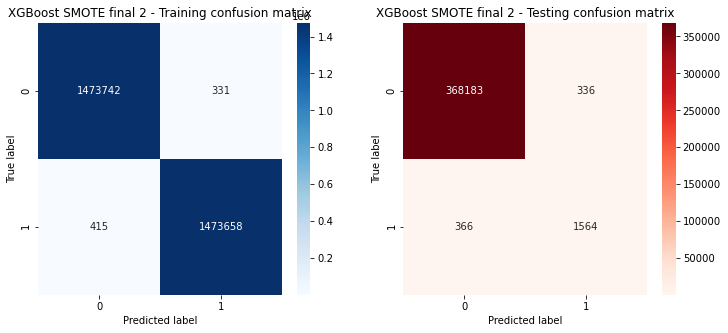

In [79]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_train_4, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('XGBoost SMOTE final 2 - Training confusion matrix')

sns.heatmap(cm_test_4, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('XGBoost SMOTE final 2 - Testing confusion matrix')

### 4b. Classification Report

In [81]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_sm_np, y_pred_train_4, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_4, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00   1474073
       fraud       1.00      1.00      1.00   1474073

    accuracy                           1.00   2948146
   macro avg       1.00      1.00      1.00   2948146
weighted avg       1.00      1.00      1.00   2948146

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00    368519
       fraud       0.82      0.81      0.82      1930

    accuracy                           1.00    370449
   macro avg       0.91      0.90      0.91    370449
weighted avg       1.00      1.00      1.00    370449



In [82]:
train_report_4 = classification_report(y_train_sm, y_pred_train_4, target_names=target_names, output_dict = True)
test_report_4 = classification_report(y_test, y_pred_test_4, target_names=target_names, output_dict = True)

add_metrics('XGBoost(post randomsearch v2)', 'SMOTE', train_report_4, test_report_4)
metrics

,Algorithm,Class Balancing,Train Precision,Train Recall,Train f1,Train Support,Test Precision,Test Recall,Test f1,Test Support
0,Logistic Regression,Random Under Sampling,0.900475,0.860122,0.879836,7721,0.043136,0.859067,0.082146,1930
1,Logistic Regression,Random Over Sampling,0.897946,0.858799,0.877937,1474073,0.043753,0.854404,0.083243,1930
2,Logistic Regression,SMOTE,0.900986,0.863715,0.881957,1474073,0.045073,0.854922,0.085632,1930
3,Logistic Regression,Balanced weight,0.044084,0.858568,0.083862,7721,0.043811,0.854404,0.083348,1930
4,Random Forest,Random Under Sampling,1.000000,1.000000,1.000000,7721,0.199521,0.949223,0.329734,1930
5,Random Forest,Random Over Sampling,1.000000,1.000000,1.000000,1474073,0.931694,0.706736,0.803771,1930
6,Random Forest,SMOTE,1.000000,1.000000,1.000000,1474073,0.775593,0.796891,0.786098,1930
7,Random Forest,Balanced weight,1.000000,0.999352,0.999676,7721,0.961029,0.638860,0.767507,1930
8,XGBoost,Random Under Sampling,0.999870,0.999741,0.999806,7721,0.192803,0.977202,0.322063,1930
9,XGBoost,Random Over Sampling,0.993546,1.000000,0.996763,1474073,0.418360,0.949223,0.580758,1930


### 4c. ROC Curve

In [137]:
# get predicted probabilities
y_scores_4 = xg_sm_final2.predict_proba(X_test_np)[:,1]

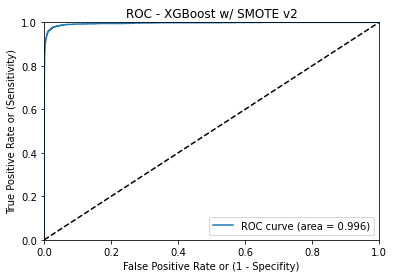

In [138]:
# Compute fpr, tpr, thresholds and roc auc
fpr4, tpr4, thresholds4 = roc_curve(y_test_np, y_scores_4)
roc_auc4 = auc(fpr4, tpr4)

# Plot ROC curve
plt.plot(fpr4, tpr4, label='ROC curve (area = %0.3f)' % roc_auc4)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('ROC - XGBoost w/ SMOTE v2')
plt.legend(loc="lower right")

### 4d. Precision-Recall Curve

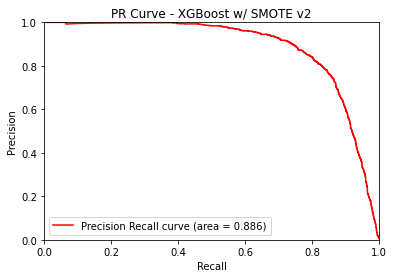

In [139]:
precision4, recall4, threshold4 = precision_recall_curve(y_test_np, y_scores_4)
# Use AUC function to calculate the area under the curve of precision recall curve
pr_auc4 = auc(recall4, precision4)

plt.plot(recall4, precision4, label='Precision Recall curve (area = %0.3f)' % pr_auc4, color = 'red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve - XGBoost w/ SMOTE v2')
plt.legend(loc="lower left")

## Compare AUCROC and AUCPR scores

In [142]:
auc_scores = {'model': ['Random Forest ROS', 'Random Forest SMOTE', 'XGBoost SMOTE', 'XGBoost SMOTE v2'] , 
              'AUCROC': [roc_auc1, roc_auc2, roc_auc3, roc_auc4], 
              'AUCPR': [pr_auc1, pr_auc2, pr_auc3, pr_auc4]}

In [144]:
auc_scores_df = pd.DataFrame(auc_scores)
auc_scores_df

,model,AUCROC,AUCPR
0,Random Forest ROS,0.990841,0.877799
1,Random Forest SMOTE,0.992588,0.848457
2,XGBoost SMOTE,0.996636,0.891121
3,XGBoost SMOTE v2,0.996004,0.886168


## Model Selection:

Our attempt to finetune the hyperparameters even more did not result in better performance in our test set.  As a result, we will stick with our  XGBoost algorithm with SMOTE from our initial round of hyperparameter tuning as our model.

Based on the precision and recall scores, this model detects 81% of all actual fraudulent transactions from the test set and 85% of its transactions labeled as fraudulent from the test set are correct.

Here is the model with all of its parameters:

In [147]:
xg_sm_final

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.7999999999999999, colsample_bynode=1,
              colsample_bytree=0.8999999999999999, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

And once again, here are the confusion matrices and the classification reports.

Text(0.5, 1.0, 'XGBoost SMOTE final - Testing confusion matrix')

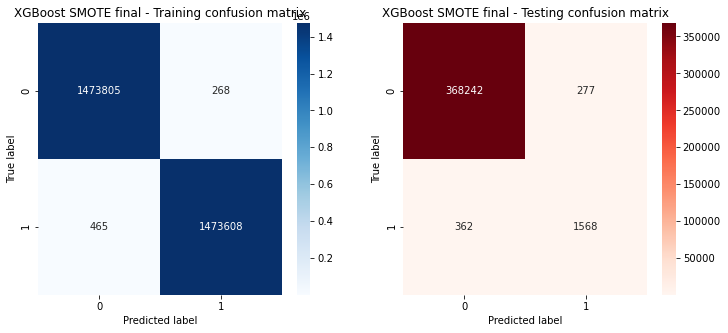

In [145]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_train_3, annot=True, fmt = '', cmap = 'Blues',ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('XGBoost SMOTE final - Training confusion matrix')

sns.heatmap(cm_test_3, annot=True, fmt = '', cmap = 'Reds',ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('XGBoost SMOTE final - Testing confusion matrix')

In [146]:
target_names = ['valid', 'fraud']

print("[Training Classification Report]")
print(classification_report(y_train_sm_np, y_pred_train_3, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(y_test_np, y_pred_test_3, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00   1474073
       fraud       1.00      1.00      1.00   1474073

    accuracy                           1.00   2948146
   macro avg       1.00      1.00      1.00   2948146
weighted avg       1.00      1.00      1.00   2948146

[Test Classification Report]
              precision    recall  f1-score   support

       valid       1.00      1.00      1.00    368519
       fraud       0.85      0.81      0.83      1930

    accuracy                           1.00    370449
   macro avg       0.92      0.91      0.91    370449
weighted avg       1.00      1.00      1.00    370449



## Feature importances

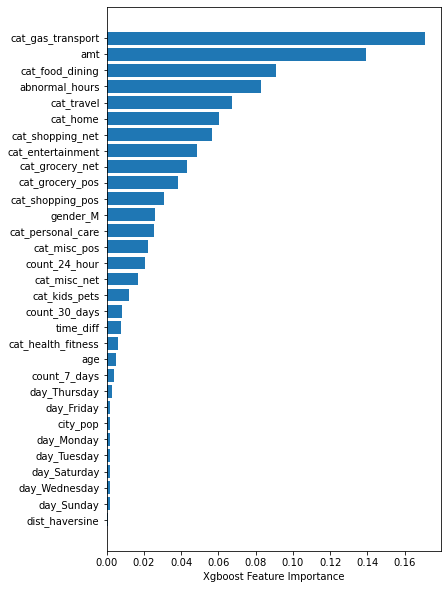

In [141]:
fig, ax = plt.subplots(figsize = (6, 10))
ax.barh(X_test.columns[sorted_idx], xg_sm_final.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

Our top 5 most important features are:

1. cat_gas_transport
2. amt
3. cat_food_dining
4. abnormal_hours
5. cat_travel

## Feature Impact computed with SHAP

In [106]:
from shap import TreeExplainer

explainer = shap.TreeExplainer(xg_sm_final)
shap_values = explainer.shap_values(X_test_np)

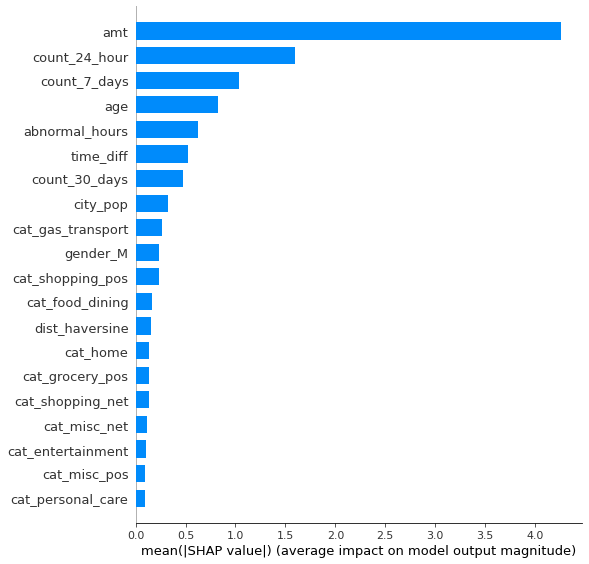

In [107]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

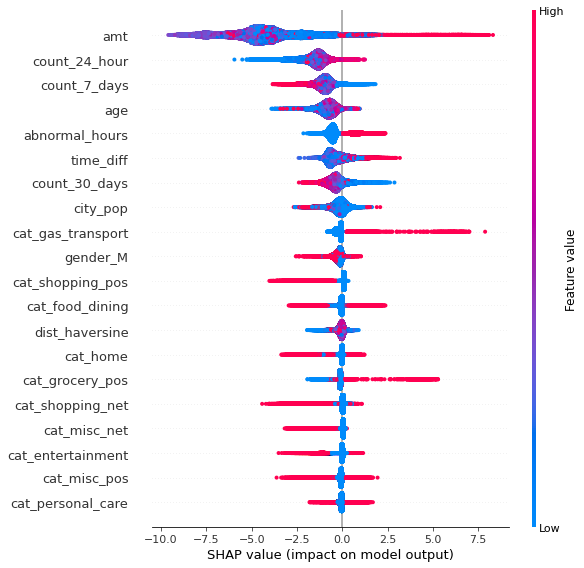

In [108]:
shap.summary_plot(shap_values, X_test)

Based on the SHAP summary plot, we can interpret the impact of our features as follows:

- When the <b>'amt'</b> is high, it increases the likelihood that the transaction may be fraud.
- When the <b>number of transactions in the last 24 hours</b> ('count_24_hour') is high, it increases the likelihood that the transaction may be fraud.
    - This may be a result of a stolen credit card being used multiple times shortly after it was stolen.
- In contrast, when the <b>number of transactions in the last 7 days</b> is <b>low</b>, it increases the likelihood that the transaction may be fraud.
    - This may be because after a stolen credit card is used on multiple occasions in the first 24 hours, it may be discarded by the thief.
- When the transaction takes place during <b>abnormal hours</b>, it increases the likelihood that the transaction may be fraud.
- When the transaction is in the <b>gas_transport</b> category ('cat_gas_transport' = 1), it increases the likelihood that the transaction may be fraud.

## Future direction

There is still room to improve the model. 

- We could have revisited the Logistic Regression algorithm and apply hyperparameter tuning to see if its performance would beat the other three models we used in this notebook.
- For our initial twelve models, we tested three resampling methods (random oversampling, random undersampling, and SMOTE).  We can also try alternative methods such as Near Miss Undersampling and Borderine-SMOTE. 
- There may be more features that we can engineer, such as the number of unique states that the last 3, 5, or 7 transactions were in.
- There are also other algorithms that we did not try, such as Naive Bayes, Support Vector Machines, and Stochastic Gradient Boosting.